In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17461845183014503666,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17089407072461357183
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3180081971
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15990238852111405817
 physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3088972264577526598
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
# teacher <- discriminator
# student <- generator

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

from IPython import display

In [4]:
import os
image_dir = ".\\landscapes"
re_paths = os.path.join(image_dir, "*.jpg")
re_paths

'.\\landscapes\\*.jpg'

In [5]:
from glob import glob
image_path_list = glob(re_paths)
image_path_list[:10]

['.\\landscapes\\00000000.jpg',
 '.\\landscapes\\00000000_(2).jpg',
 '.\\landscapes\\00000000_(3).jpg',
 '.\\landscapes\\00000000_(4).jpg',
 '.\\landscapes\\00000000_(5).jpg',
 '.\\landscapes\\00000000_(6).jpg',
 '.\\landscapes\\00000000_(7).jpg',
 '.\\landscapes\\00000001.jpg',
 '.\\landscapes\\00000001_(2).jpg',
 '.\\landscapes\\00000001_(3).jpg']

In [6]:
# img = Image.open('.\\landscapes\\00000172_(6).jpg').convert('RGB')
# img = get_training_image(img)
# img_arr = np.array(img)
# img_arr = img_arr[:, :, :4]

In [7]:
pixels_mean = 127.5
pixels_std = 127.5

# map pixels (0, 255) -> (-1, 1)
def scale_image(img: np.ndarray) -> np.ndarray:
    return (img - pixels_mean) / pixels_std

# map pixels (-1, 1) -> (0, 255)
def unscale_image(img: np.ndarray) -> np.ndarray:
    return img * pixels_std + pixels_mean

In [8]:
final_image_size = 224

def get_training_image(img: Image) -> Image:
    # resize to width = 224
    factor = final_image_size / img.height
    resized_width = int(factor * img.width)
    resized_height = int(factor * img.height)
    img = img.resize((resized_width, resized_height))

    # apply random crop on horizontal (x) axis
    if resized_width > final_image_size:
        x_left = np.random.randint(0, resized_width - final_image_size)
    else: 
        x_left = 0
    img = img.crop((x_left, 0, x_left + final_image_size, final_image_size))
    return img

In [9]:
def reading_generator():
    for idx, img_path in enumerate(image_path_list):
        img = Image.open(img_path).convert('RGB')
        img = get_training_image(img)
        
        img_arr = np.array(img)
        if len(img_arr.shape) < 3:
            raise Exception(f'{img_path} - {img_arr.shape}')
        
        img_arr = scale_image(img_arr)
        yield img_arr

In [10]:
BUFFER_SIZE = len(image_path_list)
BATCH_SIZE = 8

dataset = tf.data.Dataset.from_generator(reading_generator, output_types=tf.float64).cache()
dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).repeat()

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, \
                                    Conv2DTranspose, Conv2D, Flatten, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html

In [12]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7 * 7 * 1024, use_bias=False, input_shape=(1000,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 1024)))
    assert model.output_shape == (None, 7, 7, 1024) # Note: None is the batch size

    model.add(Conv2DTranspose(512, (7, 7), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 512)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 14, 14, 256)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(8, (7, 7), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 112, 112, 8)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, 
                                     activation='tanh'))
    assert model.output_shape == (None, 224, 224, 3)

    return model

In [13]:
generator = make_generator_model()

(None, 14, 14, 256)


In [27]:
noise = tf.random.uniform(shape=[1, 1000], minval=-1, maxval=1, dtype=tf.float32)
generated_image = generator(noise, training=False).numpy()

generated_image = np.round(unscale_image(generated_image))
generated_image = generated_image.astype(int)

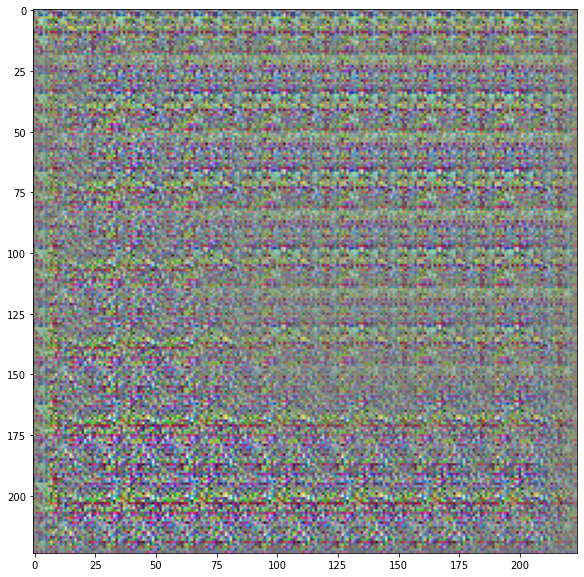

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(generated_image[0])

In [16]:
from tensorflow.keras.applications import ResNet50
resnet = ResNet50(weights='imagenet', input_shape=(224, 224, 3))

In [17]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
def make_discriminator_model():
    model_layers = [resnet]
    model_layers.append(Dropout(0.1))
    model_layers.append(Dense(256, activation='relu'))
    model_layers.append(Dropout(0.2))
    model_layers.append(Dense(1, activation='linear'))

    model = Sequential(model_layers)
    return model

In [19]:
discriminator = make_discriminator_model()
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00393698]], dtype=float32)>

In [20]:
cross_entropy = BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
# different losses and different optimizires for each network
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [24]:
checkpoint_dir = '.\\training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [25]:
ckps = [d for d in os.listdir(checkpoint_dir)]
if len(ckps):
    ckp_id = len(ckps) // 3
else:
    ckp_id = 1
ckp_dir = os.path.join(checkpoint_dir, 'ckpt-'+ str(ckp_id))

In [26]:
# get latest checkpoint
checkpoint.restore(ckp_dir)

generator_optimizer = checkpoint.generator_optimizer
discriminator_optimizer = checkpoint.discriminator_optimizer
generator = checkpoint.generator
discriminator = checkpoint.discriminator

In [25]:
EPOCHS = 2
noise_dim = 1000
num_examples_to_generate = 8

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
TRAINING_STEPS = 600

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for index, image_batch in enumerate(dataset):
            train_step(image_batch)
            
            print(f'Training step {index}/{TRAINING_STEPS}', end='\r')
            if index > TRAINING_STEPS:
                break

        # Produce images for the GIF as we go
#         display.clear_output(wait=True)
#         generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        # if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
#     display.clear_output(wait=True)
#     generate_and_save_images(generator, epochs, seed)

In [28]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(2, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i+1)
        plt.imshow(unscale_image(predictions[i]))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [29]:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/tutorials/generative/dcgan
# https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


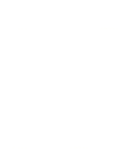

In [30]:
train(dataset, EPOCHS)